## Transfer Learning

### import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.backend import clear_session

### VGG16 model

In [16]:
IMAGE_SIZE = [128,128]
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [17]:
#dont train existing weight
for layer in vgg.layers:
    layer.trainable = False

In [18]:
folder = glob('pneumonia_data/train/*')
#we need to add more data
x = Flatten()(vgg.output)
prediction = Dense(len(folder), activation = tf.nn.softmax)(x)
model = Model(inputs = vgg.input, outputs = prediction)

In [19]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)      

In [20]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy']
)

In [21]:
#import image from datasets using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  featurewise_center = False, #set input mean 0 over the data
                                  samplewise_center = False, #set each sample mean 0
                                  featurewise_std_normalization=False, #divide inputs by std of the datasets
                                  zca_whitening = False,
                                  rotation_range=10, #randomly rotate images in the range 0-100
                                  width_shift_range = 0.2, #randomly shift image vertically. fraction of total height.
                                  vertical_flip = False
                                  )

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('pneumonia_data/train',
                                                target_size=(128,128),
                                                batch_size=16,
                                                class_mode='categorical')

test_set = test_datagen.flow_from_directory('pneumonia_data/test',
                                            target_size=(128,128),
                                            batch_size=16,
                                            class_mode='categorical')

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
#train model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=5232//16,
  validation_steps=len(test_set)
)

Epoch 1/5
327/327 [==============================] - 3715s 11s/step - loss: 0.2287 - accuracy: 0.8995 - val_loss: 0.3489 - val_accuracy: 0.8718
Epoch 2/5
327/327 [==============================] - 3298s 10s/step - loss: 0.1664 - accuracy: 0.9350 - val_loss: 0.2536 - val_accuracy: 0.9087
Epoch 3/5
327/327 [==============================] - 3157s 10s/step - loss: 0.1430 - accuracy: 0.9472 - val_loss: 0.3495 - val_accuracy: 0.8766
Epoch 4/5
327/327 [==============================] - 3167s 10s/step - loss: 0.1339 - accuracy: 0.9463 - val_loss: 0.2824 - val_accuracy: 0.9054
Epoch 5/5
327/327 [==============================] - 3163s 10s/step - loss: 0.1275 - accuracy: 0.9520 - val_loss: 0.3262 - val_accuracy: 0.8718


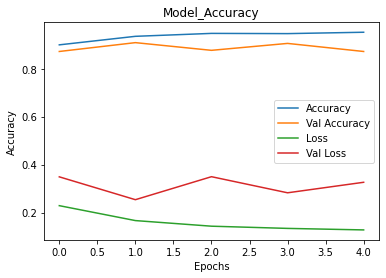

In [42]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy','Val Accuracy','Loss','Val Loss'])
plt.show()

In [43]:
model.save('model.h5')

#### test our model

In [49]:
def predict(image_path):
    model = load_model('model.h5')
    img = image.load_img(image_path, target_size=(128,128))
    #processing the image
    x = image.img_to_array(img)
    x = x/255  #scaling
    x = np.expand_dims(x, axis=0)
    
    x = preprocess_input(x)
    prediction = model.predict(x)
    clear_session()
    prediction = np.argmax(prediction, axis=1)
    return prediction

In [50]:
#image_path ='covid.png'
#image_path = 'Normal.jpeg'
image_path = 'person1_virus_7.jpeg'
predict(image_path)[0]

1